In [35]:
import sympy as sp
import numpy as np

def from_ham_symb(N):
    """Construct an MPO from a Hamiltonian with short and long range 2 body interactions.

    Args:
        ham (Hamiltonian): Hamiltonian to be converted to an MPO.

    Raises:
        NotImplementedError: Type of Hamiltonian not supported.

    Returns:
        MPO (List[array]): List of tensors representing the MPO (1 tensor for each qubit)
        offset (float): Offset for the energy of the Hamiltonian
    """
    #TODO: Include offset inside the MPO
    # n_qubits = 0
    # coeffs = {}
    # offset = 0

    # if isinstance(ham, np.ndarray):
    #     n_qubits = ham.shape[0]
    #     for i in range(n_qubits):
    #         for j in range(i, n_qubits):
    #             if ham[i, j] != 0:
    #                 coeffs[tuple(set((i, j)))] = ham[i, j]

    # Start building the Tensor Network
    N_by_2 = int(N / 2)

    a_list = [np.zeros((k + 2, k + 3), dtype=object) for k in range(1, N_by_2)]

    aux = 2 if N % 2 == 0 else 3
    a_list += [np.zeros((N_by_2 + 2, N_by_2 + aux), dtype=object)]

    a_list += [np.zeros((N - k + 3, N - k + 2), dtype=object) for k in range(N_by_2 + 1, N + 1)]

    for k in range(1, N+1):
        a_list[k-1][0,0] = 1
        a_list[k-1][-1,-1] = 1
        a_list[k-1][-2,-1] = sp.Symbol(f'Z_{k}')
        a_list[k-1][0,-1] = sp.Symbol(f'X_{k}')*sp.Symbol(f'c_x{k}')
        
        if k < N_by_2:
            a_list[k-1][0,1] = sp.Symbol(f'Z_{k}')
            a_list[k-1][0,k+1] = sp.Symbol(f'Z_{k}')*sp.Symbol(f'c_{k},{k+1}')

            for m in range(2, k+1):
                a_list[k-1][m-1, m] = 1
                a_list[k-1][m-1, k+1] = sp.Symbol(f'c_{k-m+1},{k+1}')

        elif k == N_by_2:
            for n in range(2, N_by_2 + aux):
                a_list[k-1][0, n-1] = sp.Symbol(f'Z_{k}')*sp.Symbol(f'c_{N_by_2},{N-n+2}')
                for m in range(2, k+1):
                    a_list[k-1][m-1, n-1] = sp.Symbol(f'c_{N_by_2-m+1},{N-n+2}')

        else: # k+1 > N_by_2:
            for m in range(2, N-k+2):
                a_list[k-1][0, m-1] = sp.Symbol(f'Z_{k}')*sp.Symbol(f'c_{k},{N-m+2}')
                a_list[k-1][m-1, m-1] = 1

    a_list[0] = a_list[0][0, :]
    a_list[-1] = a_list[-1][:, -1]

    tn = a_list[0]
    
    for i in range(N - 1):
        tn = np.matmul(tn, a_list[i+1])

    # tn = [a_list[0].transpose(1, 2, 0)]
    # tn += [
    #     ncon([t_list[i], a_list[i + 1]], [[-1, 1], [1, -4, -2, -3]])
    #     for i in range(len(t_list) - 1)
    # ]
    # tn += [ncon([t_list[-1], a_list[-1]], [[-1, 1], [1, -2, -3]])]


    return tn, a_list

In [36]:
from visualization import plot_diagram_from_matrix 

N = 5

symb_ham, a_list = from_ham_symb(N)

symb_ham

X_1*c_x1 + X_2*c_x2 + X_3*c_x3 + X_4*c_x4 + X_5*c_x5 + Z_1*Z_2*c_1,2 + Z_3*(Z_1*c_1,3 + Z_2*c_2,3) + Z_4*(Z_1*c_1,4 + Z_2*c_2,4 + Z_3*c_3,4) + Z_5*(Z_1*c_1,5 + Z_2*c_2,5 + Z_3*c_3,5 + Z_4*c_4,5)

************************************
[1 Z_1 Z_1*c_1,2 X_1*c_x1]
************************************
0, 0 -> 1
0, 1 -> Z_2*c_2,5
0, 2 -> Z_2*c_2,4
0, 3 -> Z_2*c_2,3
0, 4 -> X_2*c_x2
1, 1 -> c_1,5
1, 2 -> c_1,4
1, 3 -> c_1,3
2, 4 -> Z_2
3, 4 -> 1


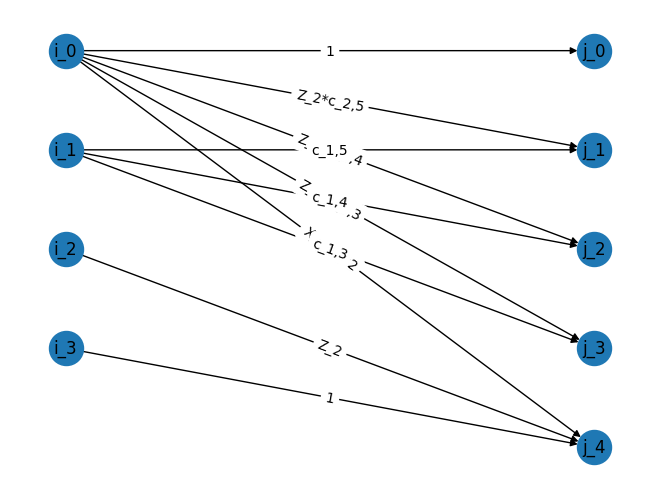

************************************
0, 0 -> 1
0, 1 -> Z_3*c_3,5
0, 2 -> Z_3*c_3,4
0, 3 -> X_3*c_x3
1, 1 -> 1
2, 2 -> 1
3, 3 -> Z_3
4, 3 -> 1


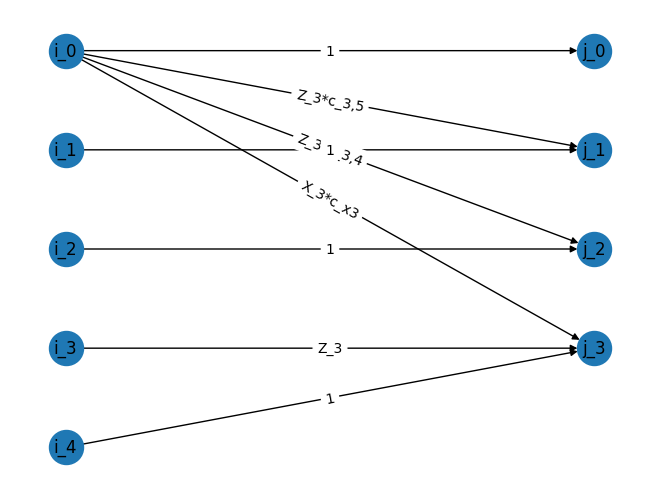

************************************
0, 0 -> 1
0, 1 -> Z_4*c_4,5
0, 2 -> X_4*c_x4
1, 1 -> 1
2, 2 -> Z_4
3, 2 -> 1


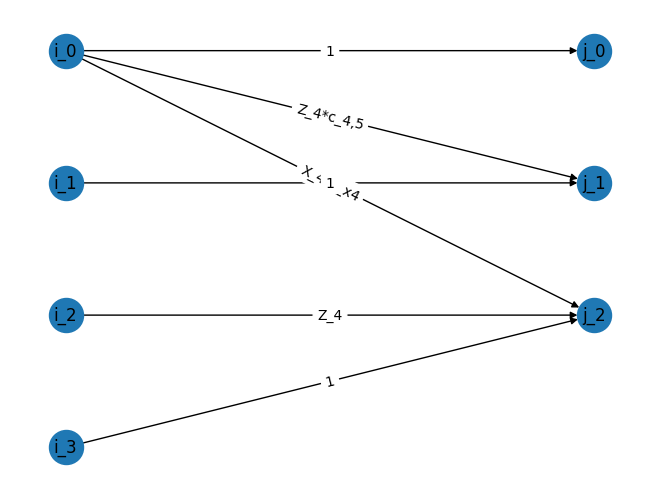

************************************
[X_5*c_x5 Z_5 1]


In [37]:
print('************************************')
print(a_list[0])
print('************************************')

for i in range(1, len(a_list)-1):
    plot_diagram_from_matrix(a_list[i])

print(a_list[-1])